In [1]:
%load_ext autoreload
%autoreload 2
from confignb import *

X, y, pts, ks, masks = util.load_data('data/processed/ASCADv.h5')
X_atk, _, pts_atk, ks_atk, _ = util.load_data('data/raw/ASCADv.h5', attack=True)

In [4]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=10,
    random_state=SEED,
    n_jobs=-1,
)

results, aux = eval_model(
    SEED, rf,
    X, y, pts, ks,
    X_atk, pts_atk, ks_atk,
    score_fn=util.compute_pge,
    n_repeats=10
)

20:19:19: FOLD 1: PROF=1.7264; ATK=1.2608
20:20:10: FOLD 2: PROF=1.7264; ATK=1.2298
20:21:01: FOLD 3: PROF=1.7264; ATK=1.1572
20:21:52: FOLD 4: PROF=1.7264; ATK=1.0854
20:22:43: FOLD 5: PROF=1.7264; ATK=1.6152
20:23:34: FOLD 6: PROF=1.7264; ATK=1.2682
20:24:25: FOLD 7: PROF=1.7264; ATK=1.0673
20:25:15: FOLD 8: PROF=1.7264; ATK=1.2884
20:26:06: FOLD 9: PROF=1.7264; ATK=1.1076
20:26:57: FOLD 10: PROF=1.7264; ATK=1.2858
[Parallel(n_jobs=1)]: Done 10 out of 10 | elapsed:  8.5min finished


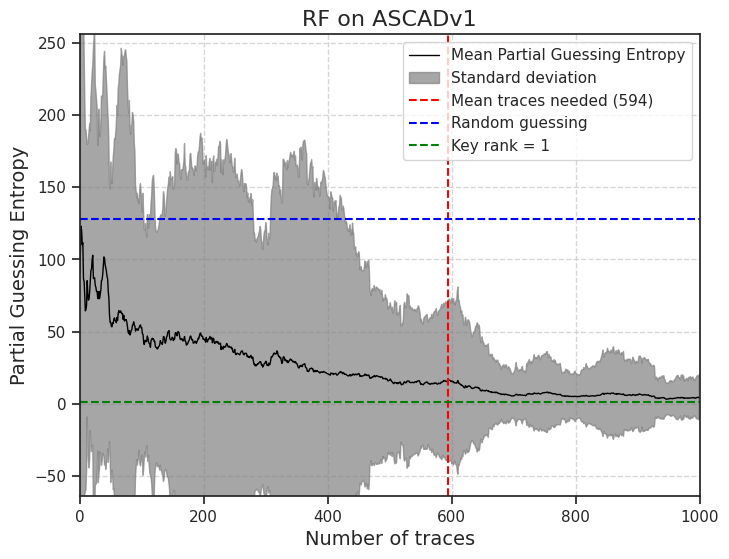

In [6]:
mr_atk = np.array([a[0] for a in aux[1]])
frs = [int(a[1]) for a in aux[1]]

fig, ax = plt.subplots(figsize=(8, 6))
plots.plot_mean_std(mr_atk[:, :1000], ax=ax)
ax.axvline(np.mean(frs), color='red', linestyle='--')
ax.axhline(128, color='blue', linestyle='--')
ax.axhline(1, color='green', linestyle='--')
ax.set_ylim(-64, 256)
plots.labs(ax, "Number of traces", "Partial Guessing Entropy", title="RF on ASCADv1")
ax.legend(["Mean Partial Guessing Entropy",
           "Standard deviation",
           f"Mean traces needed ({np.mean(frs):.0f})",
           "Random guessing",
           "Key rank = 1"])
plots.savetight(fig, "09_rf_ascadv1")

In [2]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = make_pipeline(
    PCA(n_components=10, random_state=SEED),
    StandardScaler(),
    QuadraticDiscriminantAnalysis(solver='eigen', shrinkage='auto'),
)

results, aux = eval_model(
    SEED, qda,
    X, y, pts, ks,
    X_atk, pts_atk, ks_atk,
    score_fn=util.compute_pge,
    n_repeats=10
)

20:16:12: FOLD 1: PROF=2.4299; ATK=1.0636
20:16:27: FOLD 2: PROF=2.4299; ATK=1.0363
20:16:43: FOLD 3: PROF=2.4299; ATK=1.0953
20:16:57: FOLD 4: PROF=2.4299; ATK=1.0308
20:17:12: FOLD 5: PROF=2.4299; ATK=1.0306
20:17:27: FOLD 6: PROF=2.4299; ATK=1.0116
20:17:42: FOLD 7: PROF=2.4299; ATK=1.0132
20:17:57: FOLD 8: PROF=2.4299; ATK=1.0170
20:18:12: FOLD 9: PROF=2.4299; ATK=1.0042
20:18:26: FOLD 10: PROF=2.4299; ATK=1.0293
[Parallel(n_jobs=1)]: Done 10 out of 10 | elapsed:  2.5min finished


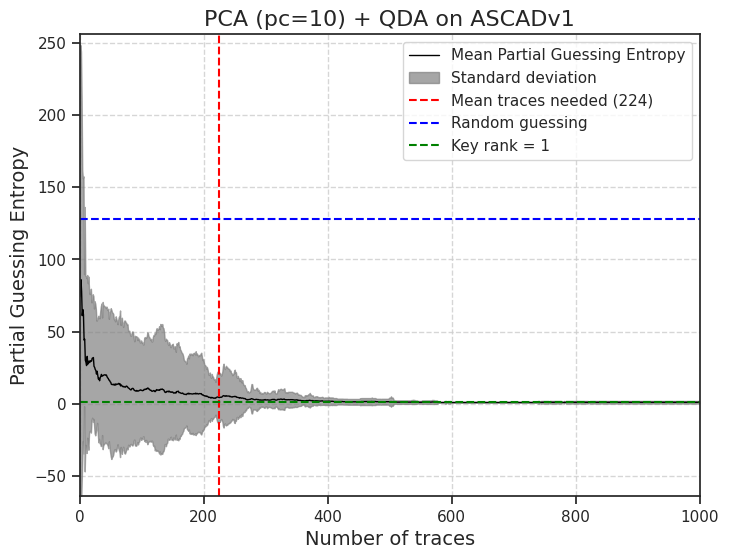

In [3]:
mr_atk = np.array([a[0] for a in aux[1]])
frs = [int(a[1]) for a in aux[1]]

fig, ax = plt.subplots(figsize=(8, 6))
plots.plot_mean_std(mr_atk[:, :1000], ax=ax)
ax.axvline(np.mean(frs), color='red', linestyle='--')
ax.axhline(128, color='blue', linestyle='--')
ax.axhline(1, color='green', linestyle='--')
ax.set_ylim(-64, 256)
plots.labs(ax, "Number of traces", "Partial Guessing Entropy", title="PCA (pc=10) + QDA on ASCADv1")
ax.legend(["Mean Partial Guessing Entropy",
           "Standard deviation",
           f"Mean traces needed ({np.mean(frs):.0f})",
           "Random guessing",
           "Key rank = 1"])
plots.savetight(fig, "09_qda_ascadv1")

In [4]:
import onnxruntime as ort

sess = ort.InferenceSession("nn/mlp.onnx")

In [11]:
results, aux = eval_onnx(SEED, sess, X_atk, pts_atk, ks_atk, n_repeats=10)

  0%|          | 0/10 [00:00<?, ?it/s]

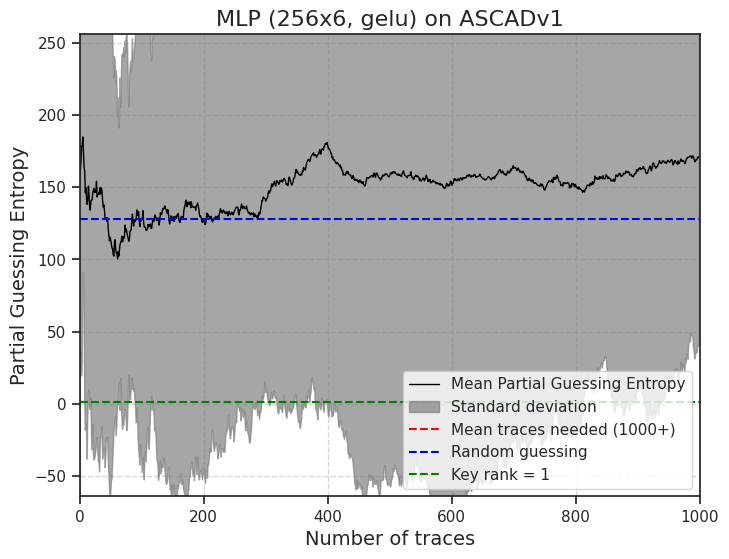

In [14]:
mr_atk = np.array([a[0] for a in aux[1]])
frs = [int(a[1]) for a in aux[1]]

fig, ax = plt.subplots(figsize=(8, 6))
plots.plot_mean_std(mr_atk[:, :1000], ax=ax)
ax.axvline(np.mean(frs), color='red', linestyle='--')
ax.axhline(128, color='blue', linestyle='--')
ax.axhline(1, color='green', linestyle='--')
ax.set_ylim(-64, 256)
plots.labs(ax, "Number of traces", "Partial Guessing Entropy", title="MLP (256x6, gelu) on ASCADv1")
ax.legend(["Mean Partial Guessing Entropy",
           "Standard deviation",
           f"Mean traces needed ({np.mean(frs):.0f})" if np.mean(frs) < 1000 else "Mean traces needed (1000+)",
           "Random guessing",
           "Key rank = 1"], loc='lower right')
plots.savetight(fig, "09_qda_ascadv1")